In [14]:
### for colab
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('gdrive/MyDrive/ML_data/UQ_methods')
!pip install extra_keras_datasets
!pip install mediapy

ModuleNotFoundError: No module named 'google.colab'

In [100]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_probability as tfp
import sys
sys.path.append('../')

from utility.mnist_data import adversarial_data
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from keras.datasets import mnist
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from tensorflow.python.keras import backend
from tensorflow.keras.models import Model
import seaborn as sns
try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
    
import mediapy as media
from extra_keras_datasets import emnist
import pandas as pd
from scipy.stats import ttest_ind,kstest

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import pickle
import matplotlib.image as mpimg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
# Building out MINST dataset
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

In [118]:
import sys
sys.path.append('../')

from utility.mnist_data.adversarial_data import MNIST_EMNIST,compute_dropout_uncertainty

data=MNIST_EMNIST()


INFO:root:Loading dataset = emnist


# Setting up the data: training with numbers, attacking with letters



In [119]:
# vanilla data
trainers,adversarials=data.get_taste_test()
print('Training Data')

media.show_images(trainers,columns=10,  border=True, height=100,cmap='flare')
print('Adversarial Data')
media.show_images(adversarials,columns=10,  border=True, height=100,cmap='flare')


Training Data


,,,,,,,,,


Adversarial Data


,,,,,,,,,


In [121]:
trainers[0].shape

(28, 28, 1)

/Users/nicholas.rossi/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicholas.rossi/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


AttributeError: 'AxesSubplot' object has no attribute 'set_titile'

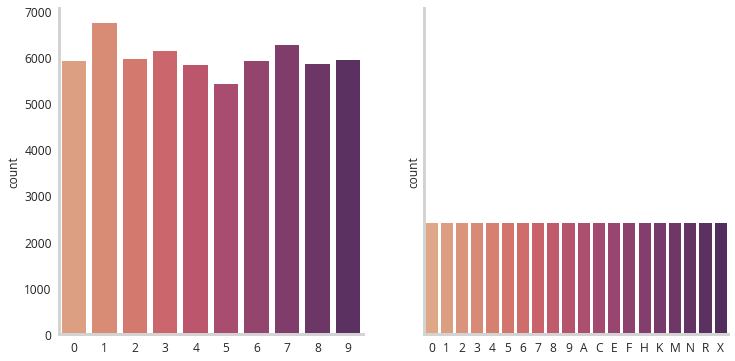

In [330]:
# data counts
fig,ax=plt.subplots(1,2,figsize=(12,6),sharey=True)

sns.countplot(data.train_keys,palette='flare',ax=ax[0])
# ax[1].set_xticklabels([0,1,2,3,4,5,6,7,8,9])

sns.countplot(data.holdout_training_keys,palette='flare',ax=ax[1])
ax[1].set_xticklabels([0,1,2,3,4,5,6,7,8,9,'A','C','E','F','H','K','M','N','R','X'])

ax[0].set_title('Training MNIST data')
ax[1].set_title('Adversarial Data')

/Users/nicholas.rossi/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


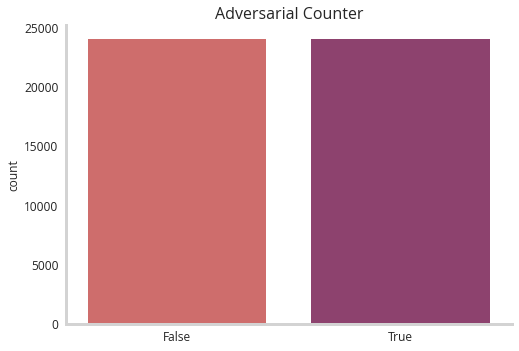

In [321]:
fig,ax=plt.subplots()
sns.countplot(data.adversarial_training_labels,palette='flare',ax=ax)
ax.set_title('Adversarial Counter')
fig.savefig('figures/adv_count.png',bbox_inches='tight',dpi=300)


# Training Model and Testing Performance

# Why you need dropout

Lets compare our shuffling and resampling of dropout for two charecters : the number 3 and the letter N. The model will be trained on digits (0-9), and expecting to see them. The letter N will be a suprise that it is not prepared for.

# Grabbing our "3" and "N" data

In [77]:
N_samples=data.X_adv_train[data.holdout_training_keys==23]
threes_samples=data.X_adv_train[data.holdout_training_keys==3]
eights_samples=data.X_adv_train[data.holdout_training_keys==8]
sevens_samples=data.X_adv_train[data.holdout_training_keys==7]

print('3s')
media.show_images(threes_samples[:10],columns=10,  border=True, height=100,cmap='flare')

print('Ns')
media.show_images(N_samples[:10],columns=10,  border=True, height=100,cmap='flare')



3s


,,,,,,,,,


Ns


,,,,,,,,,


# Comparing Models with and without Dropout

In [78]:
from utility.mnist_data.model_warehouse import *


Epoch 1/20
 257/1875 [===>..........................] - ETA: 4:02 - loss: 0.7772 - accuracy: 0.7457

KeyboardInterrupt: 

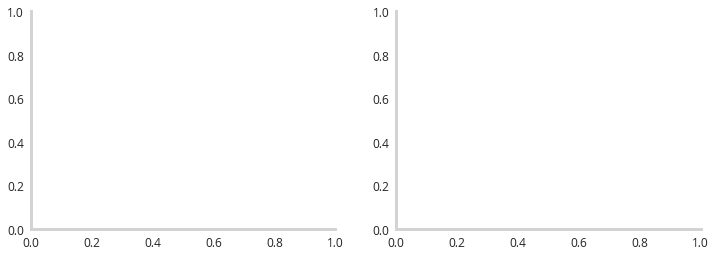

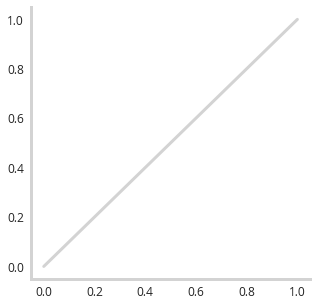

In [79]:
fig,ax=plt.subplots(1,2,figsize=(12,4),sharex=True)
labels=['thicc','thicc_norm']
meta_metrics={}
palette='flare'
colors=sns.color_palette(palette, 2)

roc_fig,roc_ax=plt.subplots(figsize=(5,5))
roc_ax.plot([0,1],[0,1],color='#d3d3d3',linewidth=3)

for i,model_type in enumerate([thicc_CNN_dropout,thicc_CNN_dropout_with_norm]):
    metrics={}
    model = model_type()
    history = model.fit(data.X_train, data.y_train, epochs=20, batch_size=32, validation_data=(data.X_test, data.y_test), verbose=1)
    
    letter_dropout_means,letter_dropout_uncertainy=compute_dropout_uncertainty(model,N_samples)
    number_dropout_means,number_dropout_uncertainy=compute_dropout_uncertainty(model,sevens_samples)
    subset=pd.DataFrame({0:np.mean(number_dropout_uncertainy,axis=1),1:np.mean(letter_dropout_uncertainy,axis=1)}).melt()

    letter_values=np.mean(letter_dropout_uncertainy,axis=1)
    number_values=np.mean(number_dropout_uncertainy,axis=1)
    letter_mean=np.round(np.mean(letter_dropout_uncertainy),2)
    number_mean=np.round(np.mean(number_dropout_uncertainy),2)
    
    metrics['k_metric']=kstest(letter_values,number_values)[0]
    
    metrics['diff_means']=letter_mean-number_mean

    print(f'{labels[i]}, letter uq : {letter_mean}, number uq :{number_mean}')
    
    sns.regplot(x="value", y="variable", data=subset,
                     logistic=True,
                n_boot=500, y_jitter=.1,line_kws={"color": colors[-1]},scatter_kws={'alpha':0.05,"color": colors[0]},ax=ax[i])
    
    ax[i].set_title(labels[i])
    ax[i].set_xlabel('Uncertainty')
    ax[i].set_yticks([0,1])
    ax[i].set_yticklabels(['8','N'])
    
    
    ### computing logistic regression
    ground=subset['variable'].values
    clf = LogisticRegression(random_state=0).fit(subset['value'].values.reshape(-1,1), ground)
    predictions=clf.predict_proba(subset['value'].values.reshape(-1,1))[:,1]
    fpr, tpr, _ = roc_curve(ground, predictions)
    roc_auc = auc(fpr, tpr)
    metrics['AUC']=roc_auc
    meta_metrics[labels[i]]=metrics

    roc_ax.plot(fpr, tpr, 
         lw=3, label=f'{labels[i]} {np.round(roc_auc,2)}',color=colors[i])

roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title(f'ROC curve \n Distinguishing between 3 and N \n based on uncertainty' )
roc_ax.legend()
roc_fig.savefig('figures/thicc_gauntlet_ROC_8.png',dpi=300,bbox_inches='tight')

    
fig.savefig('figures/thicc_gauntlet_8.png',dpi=300,bbox_inches='tight')
    

In [ ]:
# Computing classifier for adversarial /non-adversarial

In [238]:
from sklearn.linear_model import LogisticRegression

In [247]:
clf = LogisticRegression(random_state=0).fit(subset['value'].values.reshape(-1,1), subset['variable'].values)

In [260]:

predictions=clf.predict_proba(subset['value'].values.reshape(-1,1))[:,1]
ground=subset['variable'].values

Text(0.5, 1.0, 'ROC curve (AUC = 0.84)')

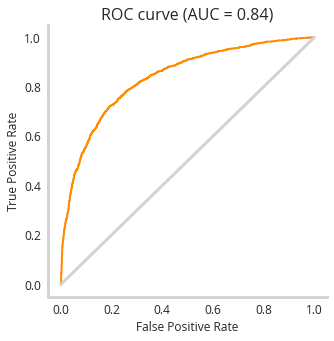

In [267]:

fpr, tpr, _ = roc_curve(ground, predictions)
roc_auc = auc(fpr, tpr)

lw = 2
# plt.figure()

fig,ax=plt.subplots(figsize=(5,5))

ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)

ax.plot([0,1],[0,1],color='#d3d3d3',linewidth=3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC curve (AUC = {np.round(roc_auc,2)})' )

# Running Complete Ecosystem

In [21]:
from utility.mnist_data.dropout_framework import DropoutMinstModel,KfoldMinstModel
from utility.mnist_data.model_warehouse import basic_CNN,deep_CNN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

INFO:root:Loading dataset = emnist
INFO:root:Starting mnist model training


Epoch 1/30
1875/1875 [==============================] - 142s 75ms/step - loss: 0.3929 - accuracy: 0.8807 - val_loss: 0.0416 - val_accuracy: 0.9855
Epoch 2/30
1875/1875 [==============================] - 134s 71ms/step - loss: 0.0735 - accuracy: 0.9784 - val_loss: 0.0303 - val_accuracy: 0.9903
Epoch 3/30
1875/1875 [==============================] - 134s 71ms/step - loss: 0.0575 - accuracy: 0.9826 - val_loss: 0.0332 - val_accuracy: 0.9892
Epoch 4/30
1875/1875 [==============================] - 141s 75ms/step - loss: 0.0490 - accuracy: 0.9853 - val_loss: 0.0226 - val_accuracy: 0.9925
Epoch 5/30
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0438 - accuracy: 0.9865 - val_loss: 0.0215 - val_accuracy: 0.9931
Epoch 6/30
1875/1875 [==============================] - 150s 80ms/step - loss: 0.0356 - accuracy: 0.9894 - val_loss: 0.0241 - val_accuracy: 0.9925
Epoch 7/30
1875/1875 [==============================] - 154s 82ms/step - loss: 0.0320 - accuracy: 0.9903 - val_loss: 0

INFO:root:mnist model trained
INFO:root:Collecting UQ from dropout
100%|██████████| 100/100 [35:43<00:00, 21.44s/it]
INFO:root:Finished collecting UQ from dropout
100%|██████████| 100/100 [04:40<00:00,  2.81s/it]


INFO:tensorflow:Assets written to: serialized_data/kaggle_example/mnist.mdl/assets


INFO:tensorflow:Assets written to: serialized_data/kaggle_example/mnist.mdl/assets


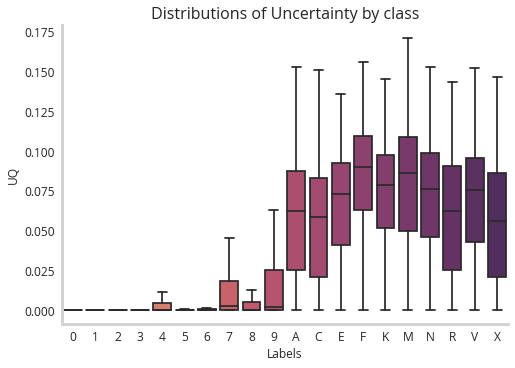

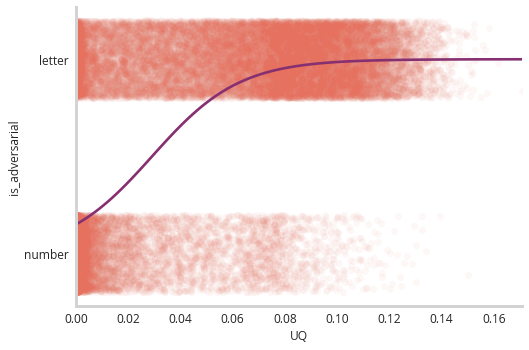

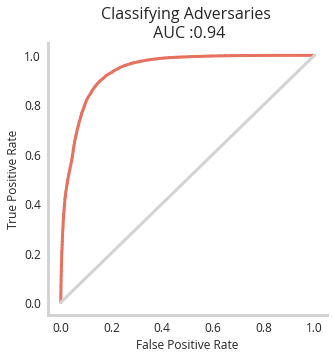

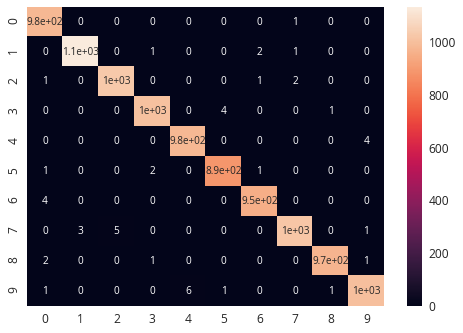

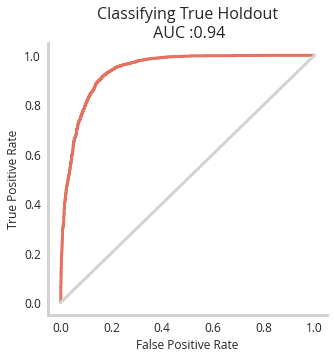

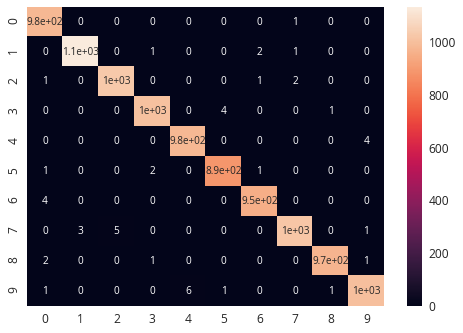

In [20]:
titles=['basic_CNN','deep_CNN']
for i, model in enumerate([kaggle_example]):

    complete_model=DropoutMinstModel(base_model=model,n_epochs=30,n_dropout_shuffles=100,title=titles[i])
    complete_model.train()
    complete_model.make_plots(f'figures/{titles[i]}')

# Visualizing Data / Comparing two solutions


In [22]:
# Loading Data
basic_uq=pd.read_csv('serialized_data/basic_cnn/uq_dataframe.csv')
deep_uq=pd.read_csv('serialized_data/deep_cnn/uq_dataframe.csv')

In [82]:
def generate_uncerainty_distributions(ax,uq_dataframe,title='Distributions of Uncertainty by class'):
    sns.boxplot(x='Labels', y='UQ', data=uq_dataframe, palette='flare', showfliers=False,ax=ax)

    ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'A', 'C', 'E', 'F', 'K', 'M', 'N', 'R','V', 'X'])
    ax.set_title(title)
    return ax

def generate_roc(ax,fpr,tpr,auc,color,label='basic'):
    ax.plot(fpr,tpr,lw=3,color=color,label=f'{label} : {np.round(auc,2)}')

    ax.plot([0, 1], [0, 1], color='#d3d3d3', linewidth=3)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC for Numbers/Letters')
    #fig.savefig(f'{output_folder}/final_roc_curve.png',dpi=300,bbox_inches='tight')
    return ax

def plot_cms(ax,cm,ticks,accuracy,label='basic'):
    
    sns.heatmap(cm, annot=True,ax=ax,yticklabels=ticks,xticklabels=ticks)
    ax.set_title(f'{label} \n accuracy:{accuracy}')
    #fig.savefig(f'{output_folder}/mnist_cm.png',dpi=300,bbox_inches='tight')

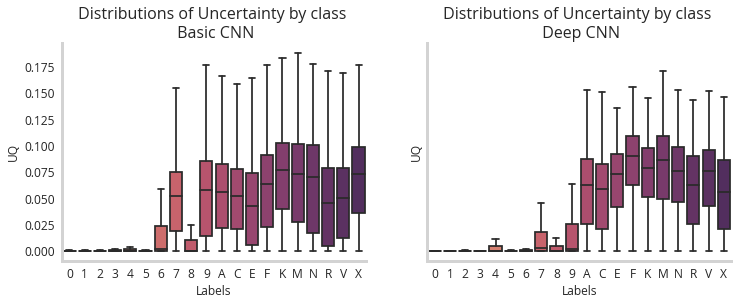

In [41]:
fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)

ax[0]=generate_uncerainty_distributions(ax[0],basic_uq,title='Distributions of Uncertainty by class \n Basic CNN')
ax[1]=generate_uncerainty_distributions(ax[1],deep_uq,title='Distributions of Uncertainty by class \n Deep CNN')
fig.savefig('figures/UQ_comp_basic_deep.png',dpi=300,bbox_inches='tight')
# fig=generate_uncerainty_distributions(deep_uq,title='Distributions of Uncertainty by class \n Deep CNN')

In [48]:
basic_metrics=pickle.load( open( 'serialized_data/basic_cnn/metrics.pkl', "rb" ) )
deep_metrics=pickle.load( open( 'serialized_data/deep_cnn/metrics.pkl', "rb" ) )

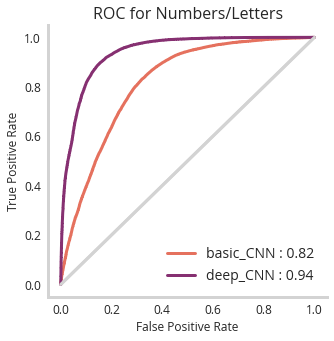

In [67]:
fig, ax = plt.subplots(figsize=(5,5))
colors=sns.color_palette('flare', 3)

ax=generate_roc(ax,basic_metrics['UQ_fpr'],basic_metrics['UQ_tpr'],basic_metrics['UQ_auc'],color=colors[0],label='basic_CNN')
ax=generate_roc(ax,deep_metrics['UQ_fpr'],deep_metrics['UQ_tpr'],deep_metrics['UQ_auc'],color=colors[2],label='deep_CNN')

ax.legend()
fig.savefig('figures/UQ_comp_basic_deep_ROC.png',dpi=300,bbox_inches='tight')


In [74]:
# computing accuracy
loaded_model = pickle.load(open('serialized_data/deep_cnn/uq.mdl', 'rb'))
predictions=loaded_model.predict(deep_uq.UQ.values.reshape(-1,1))
accuracy_score(predictions,deep_uq.is_adversarial.values)

0.8472916666666667

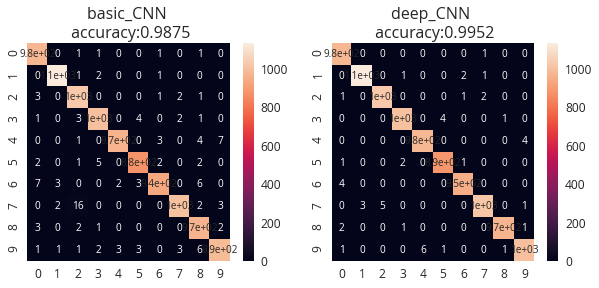

In [87]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_cms(ax[0],basic_metrics['mnist_confusion_matrix'],np.arange(10),basic_metrics['mnist_accuracy'],label='basic_CNN')
plot_cms(ax[1],deep_metrics['mnist_confusion_matrix'],np.arange(10),deep_metrics['mnist_accuracy'],label='deep_CNN')
fig.savefig('figures/confusion_mats.png',dpi=300,bbox_inches='tight')


# Testing a trained model on external challenges

In [91]:
resurection=DropoutMinstModel(base_model=deep_CNN,
                              n_epochs=30,
                              n_dropout_shuffles=100,
                              title=titles[i],
                             previous_trained_models='serialized_data/deep_cnn')


INFO:root:Loading dataset = emnist


In [277]:

def rgb2gray(rgb):
    resultant=np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    resultant = resultant.reshape((1, 28, 28, 1))
    resultant=1-resultant

    return resultant

img_loc='figures/yoda.png'
img = mpimg.imread(img_loc)     
yoda = rgb2gray(img)

img_loc='figures/zhong.png'
img = mpimg.imread(img_loc)     
zhong = rgb2gray(img)

img_loc='figures/1.png'
img = mpimg.imread(img_loc)     
eight = rgb2gray(img)

media.show_images(np.vstack([zhong,yoda,eight]),height=100,cmap='flare')


,,


In [245]:
is_adversarial,predicted_classes=resurection.predict(zhong)
print(f'is Zhong adversarial : {is_adversarial} what number is it closest to : {predicted_classes}')

100%|██████████| 100/100 [00:00<00:00, 161.18it/s]

[0.58240023]
is Zhong adversarial : [ True] what number is it closest to : [9]


In [246]:
is_adversarial,predicted_classes=resurection.predict(yoda)
print(f'is Yoda adversarial : {is_adversarial} what number is it closest to : {predicted_classes}')

100%|██████████| 100/100 [00:00<00:00, 159.82it/s]

[0.5850559]
is Yoda adversarial : [ True] what number is it closest to : [5]


In [276]:
is_adversarial,predicted_classes=resurection.predict(eight)
print(f'is eight adversarial : {is_adversarial} what number is it closest to : {predicted_classes}')

100%|██████████| 100/100 [00:00<00:00, 159.61it/s]

[0.5652839]
is eight adversarial : [ True] what number is it closest to : [1]


In [58]:


partial_model = Model(model.inputs, model.layers[-1].output)
result = []
n_iter=10
for i in range(n_iter):
    result.append(partial_model(testX))

result = np.array(result)

prediction_mean = result.mean(axis=0)
prediction_std=result.std(axis=0)
        


In [65]:


prediction_mean = result.mean(axis=0)
prediction_std=result.std(axis=0)
        

In [67]:
prediction_std[0]

array([6.7762636e-21, 5.5511151e-17, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 6.9388939e-18], dtype=float32)

In [57]:
testX.shape

(10000, 28, 28, 1)

In [39]:
testX[0].shape

(28, 28, 1)

In [75]:
X, y= emnist.load_data()


INFO:root:Loading dataset = emnist


In [77]:
y

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],